# Download package

In [4]:
!pip install pandas
!pip install librosa
!pip install seaborn
!pip install matplotlib
!pip install sciki-learn
!pip install tensorflow

ERROR: Could not find a version that satisfies the requirement sciki-learn (from versions: none)
ERROR: No matching distribution found for sciki-learn


In [5]:
import pandas as pd
import numpy as np

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio

import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Dataset

In [6]:
Crema = "/Users/hank/Downloads/AudioWAV/"
# Dataset Link: https://www.kaggle.com/datasets/ejlok1/cremad?resource=download

In [7]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

,Emotions,Path
0,angry,/Users/hank/Downloads/AudioWAV/1022_ITS_ANG_XX...
1,angry,/Users/hank/Downloads/AudioWAV/1037_ITS_ANG_XX...
2,neutral,/Users/hank/Downloads/AudioWAV/1060_ITS_NEU_XX...
3,neutral,/Users/hank/Downloads/AudioWAV/1075_ITS_NEU_XX...
4,disgust,/Users/hank/Downloads/AudioWAV/1073_IOM_DIS_XX...


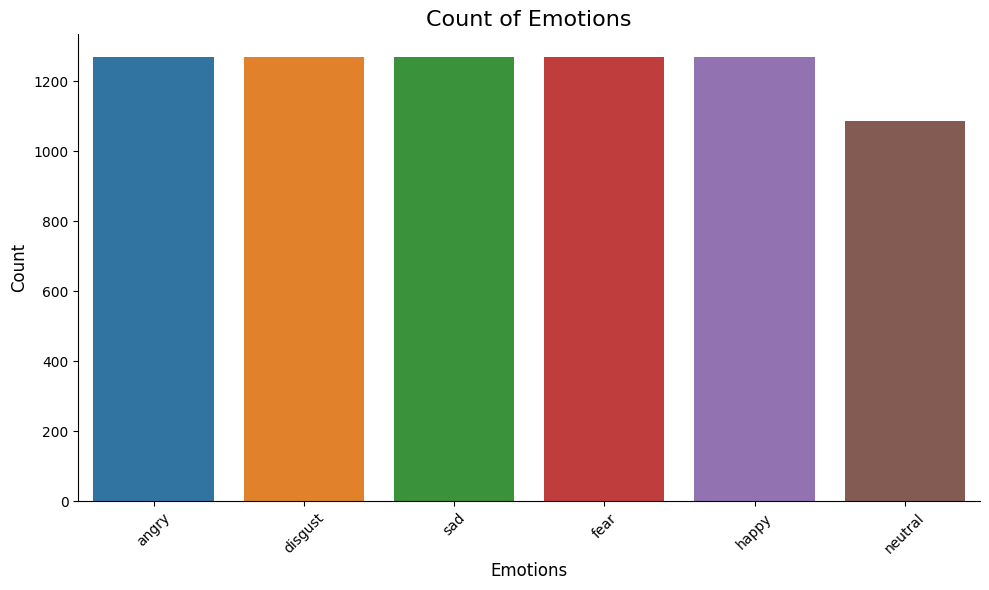

In [8]:
# Count the occurrences of each emotion
emotion_counts = Crema_df['Emotions'].value_counts()

# Plot the count using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x=emotion_counts.index, y=emotion_counts.values)
plt.title('Count of Emotions', size=16)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
sns.despine(top=True, right=True, left=False, bottom=False)
plt.tight_layout()
plt.show()


# Visualization

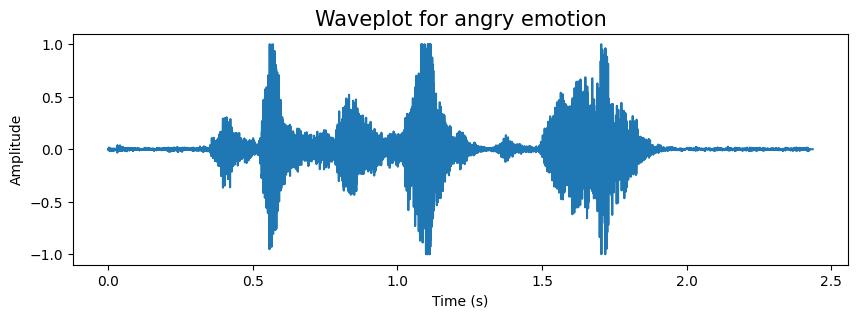

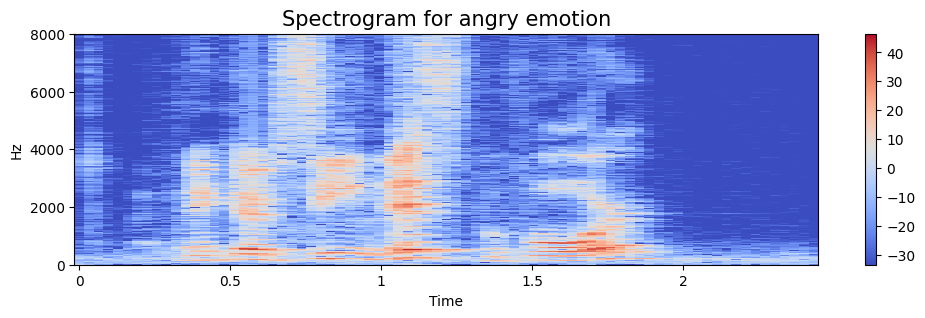

In [9]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for {} emotion'.format(e), size=15)
    plt.plot(np.linspace(0, len(data) / sr, num=len(data)), data)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()

def create_spectrogram(data, sr, e):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

emotion = 'angry'
path = np.array(Crema_df.Path[Crema_df.Emotions == emotion])[0]
data, sampling_rate = librosa.load(path, sr=None)  # sr=None loads original sampling rate
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)


# MFCC Extraction

In [11]:
labels = {'disgust': 0, 'happy': 1, 'sad': 2, 'neutral': 3, 'fear': 4, 'angry': 5}
Crema_df.replace({'Emotions': labels}, inplace=True)

num_mfcc = 13
n_fft = 2048
hop_length = 512
SAMPLE_RATE = 22050
data = {
    "labels": [],
    "mfcc": []
}
for i in range(7442):
    data['labels'].append(Crema_df.iloc[i, 0])
    signal, sample_rate = librosa.load(Crema_df.iloc[i, 1], sr=SAMPLE_RATE)
    mfcc = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
    mfcc = mfcc.T
    data["mfcc"].append(np.asarray(mfcc))
    if i % 500 == 0:
        print(i)


0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000


# Padding MFCC to make them of equal length

In [12]:
max_sequence_length = max(len(sequence) for sequence in data['mfcc'])

# Pad or truncate sequences to the maximum length
padded_mfcc = [np.pad(sequence, ((0, max_sequence_length - len(sequence)), (0, 0)), mode='constant') for sequence in data['mfcc']]

X = np.asarray(padded_mfcc)
y = np.asarray(data["labels"])


In [13]:
X = tf.keras.preprocessing.sequence.pad_sequences(X)
X.shape

(7442, 216, 13)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2)

In [15]:
print(X_train.shape,y_train.shape,X_validation.shape,y_validation.shape,X_test.shape,y_test.shape)

(5357, 216, 13) (5357,) (1340, 216, 13) (1340,) (745, 216, 13) (745,)


# Model

In [16]:
def build_model(input_shape):
    model = tf.keras.Sequential()

    model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
    model.add(LSTM(64))
    
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(6, activation='softmax'))

    return model

In [17]:
# create network
input_shape = (None,13)
model = build_model(input_shape)

# compile model
optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         72704     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                                 
Total params: 126662 (494.77 KB)
Trainable params: 126662 (494.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Training

In [50]:
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=10)

Epoch 1/10
168/168 [==============================] - 26s 157ms/step - loss: 1.7909 - accuracy: 0.1699 - val_loss: 1.7918 - val_accuracy: 0.1530
Epoch 2/10
168/168 [==============================] - 26s 154ms/step - loss: 1.7890 - accuracy: 0.1770 - val_loss: 1.7910 - val_accuracy: 0.1530
Epoch 3/10
168/168 [==============================] - 26s 155ms/step - loss: 1.7886 - accuracy: 0.1818 - val_loss: 1.7912 - val_accuracy: 0.1530
Epoch 4/10
168/168 [==============================] - 30s 180ms/step - loss: 1.7868 - accuracy: 0.1833 - val_loss: 1.7853 - val_accuracy: 0.1590
Epoch 5/10
168/168 [==============================] - 27s 159ms/step - loss: 1.7861 - accuracy: 0.1865 - val_loss: 1.7733 - val_accuracy: 0.1672
Epoch 6/10
168/168 [==============================] - 26s 157ms/step - loss: 1.6892 - accuracy: 0.2759 - val_loss: 1.5306 - val_accuracy: 0.3485
Epoch 7/10
168/168 [==============================] - 26s 152ms/step - loss: 1.5202 - accuracy: 0.3608 - val_loss: 1.5389 - val_ac

# Evaluation

In [51]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print("Test Accuracy: ",test_acc)

Test Accuracy:  0.28993287682533264


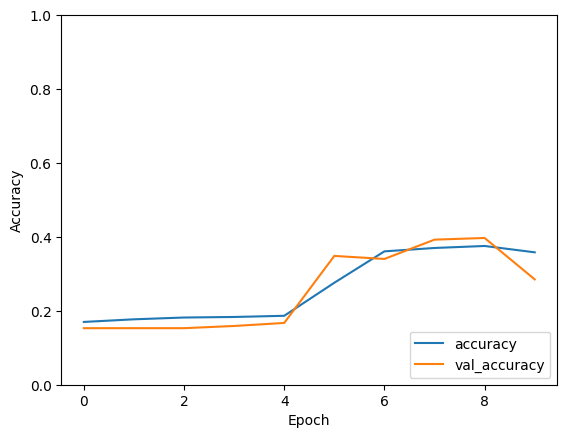

In [52]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
# Save the plot as an image
#plt.savefig('training_history.png')  # Specify the filename and format (e.g., .png)
# Display the plot
plt.show()


In [53]:
model.save('saved-model/my_model.h5')

# New Data

In [26]:
!pip install soundfile
# !pip intsall numpy
# !pip install tensorflow
# !pip install librosa

In [54]:
import os
import numpy as np
import tensorflow as tf
import librosa
import soundfile as sf

# Define paths
mp3_folder = 'self-data/self-mp3/'
wav_folder = 'self-data/self-wav/'

# Load the pre-trained model
loaded_model = tf.keras.models.load_model('saved-model/my_model.h5')

# Preprocess new .wav data
def preprocess_new_data(data):
    signal, sample_rate = librosa.load(data, sr=None)
    mfcc = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
    mfcc = mfcc.T
    padded_mfcc = np.pad(mfcc, ((0, max_sequence_length - len(mfcc)), (0, 0)), mode='constant')
    return padded_mfcc

# Create the directory for WAV files if it doesn't exist
if not os.path.exists(wav_folder):
    os.makedirs(wav_folder)

# Iterate through MP3 files
for mp3_filename in os.listdir(mp3_folder):
    if mp3_filename.endswith('.mp3'):
        print(mp3_filename)
        mp3_file_path = os.path.join(mp3_folder, mp3_filename)
        wav_filename = mp3_filename[:-4] + '.wav'
        wav_file_path = os.path.join(wav_folder, wav_filename)

        # Convert MP3 to WAV
        data, sample_rate = sf.read(mp3_file_path)
        sf.write(wav_file_path, data, sample_rate)
        print('2: ', wav_file_path)

        # Preprocess and predict
        preprocessed_data = preprocess_new_data(wav_file_path)
        predictions = loaded_model.predict(np.expand_dims(preprocessed_data, axis=0))
        predicted_class = np.argmax(predictions)
        print('3')

        # Map predicted class index to label
        labels = {0: 'disgust', 1: 'happy', 2: 'sad', 3: 'neutral', 4: 'fear', 5: 'angry'}
        predicted_label = labels[predicted_class]

        # Print results
        print("File:", wav_filename)
        print("Predicted Class Index:", predicted_class)
        print("Predicted Label:", predicted_label)
        print("-" * 40)


sad_s01.mp3
2:  self-data/self-wav/sad_s01.wav
1/1 [==============================] - 1s 791ms/step
3
File: sad_s01.wav
Predicted Class Index: 0
Predicted Label: disgust
----------------------------------------
happy_s01.mp3
2:  self-data/self-wav/happy_s01.wav
1/1 [==============================] - 0s 35ms/step
3
File: happy_s01.wav
Predicted Class Index: 0
Predicted Label: disgust
----------------------------------------
bb_s01.mp3
2:  self-data/self-wav/bb_s01.wav
1/1 [==============================] - 0s 34ms/step
3
File: bb_s01.wav
Predicted Class Index: 0
Predicted Label: disgust
----------------------------------------


## For testing single file

In [ ]:
# import numpy as np
# import tensorflow as tf
# import librosa
# import soundfile as sf

# mp3_file_path = '/Users/hank/Downloads/bb.mp3'
# wav_file_path = 'temp.wav'

# data, sample_rate = sf.read(mp3_file_path)
# sf.write(wav_file_path, data, sample_rate)

# # Preprocess new .wav data
# def preprocess_new_data(data):
#     # Load .wav file
#     signal, sample_rate = librosa.load(data, sr=None)  # Use sr=None to retain original sampling rate

#     # Perform MFCC extraction and padding
#     mfcc = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
#     mfcc = mfcc.T
#     padded_mfcc = np.pad(mfcc, ((0, max_sequence_length - len(mfcc)), (0, 0)), mode='constant')

#     return padded_mfcc

# # Load the pre-trained model
# loaded_model = tf.keras.models.load_model('saved-model/my_model.h5')

# # Preprocess and predict
# preprocessed_data = preprocess_new_data(wav_file_path)
# predictions = loaded_model.predict(np.expand_dims(preprocessed_data, axis=0))

# # Interpret predictions
# predicted_class = np.argmax(predictions)

# # Map the predicted class index to its corresponding label
# labels = {0: 'disgust', 1: 'happy', 2: 'sad', 3: 'neutral', 4: 'fear', 5: 'angry'}
# predicted_label = labels[predicted_class]

# # Print the predicted class index and label
# print("Predicted Class Index:", predicted_class)
# print("Predicted Label:", predicted_label)
